<a href="https://colab.research.google.com/github/alexandrufiruti/masterlastyear/blob/main/mlav/face_landmark_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Proiect MLAV** -  Face (Eye) Landmarks localization
*   Baza de date: Caltech 10k Web Faces ([aici](http://www.vision.caltech.edu/Image_Datasets/Caltech_10K_WebFaces/))
*   Arhitectura : ResNet-18 (detalii [aici](https://www.youtube.com/watch?v=**ZILIbUvp5lk**))



Accesare date (daca nu exista deja local):


1.   Descarcare arhiva cu *wget*
2.   Dezarhivare
3.   Stergere arhiva dupa dezarhivare



In [1]:
import os

# descarcare imagini
!rm -r *
!wget http://web-old.archive.org/web/20200917123232/http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_1.zip
!wget http://web-old.archive.org/web/20200917123232/http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_2.zip
!wget http://web-old.archive.org/web/20200917123232/http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_3.zip
!wget http://web-old.archive.org/web/20200917123232/http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_4.zip
!wget http://web-old.archive.org/web/20200917123232/http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_5.zip
!unzip '*.zip' 1>/dev/null
!mkdir all_helen
!mv helen_*/* all_helen/
!rm -r helen_*
!echo "Numarul total de imagini (antrenare & testare):"
!ls all_helen | wc -l

# descarcare adnotari
!wget http://web-old.archive.org/web/20200917123232/http://www.ifp.illinois.edu/~vuongle2/helen/data/annotation.zip
!unzip 'annotation.zip' 1>/dev/null
!rm -r annotation.zip
!ls annotation | wc -l



--2020-11-12 20:25:41--  http://web-old.archive.org/web/20200917123232/http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_1.zip
Resolving web-old.archive.org (web-old.archive.org)... 207.241.226.190
Connecting to web-old.archive.org (web-old.archive.org)|207.241.226.190|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: /web/20180102213934/http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_1.zip [following]
--2020-11-12 20:25:42--  http://web-old.archive.org/web/20180102213934/http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_1.zip
Reusing existing connection to web-old.archive.org:80.
HTTP request sent, awaiting response... 200 OK
Length: 96876123 (92M) [application/zip]
Saving to: ‘helen_1.zip’

helen_1.zip         100%[===================>]  92.39M   740KB/s    in 79s     

2020-11-12 20:27:01 (1.17 MB/s) - ‘helen_1.zip’ saved [96876123/96876123]

--2020-11-12 20:27:01--  http://web-old.archive.org/web/20200917123232/http://www.ifp.illinois.ed

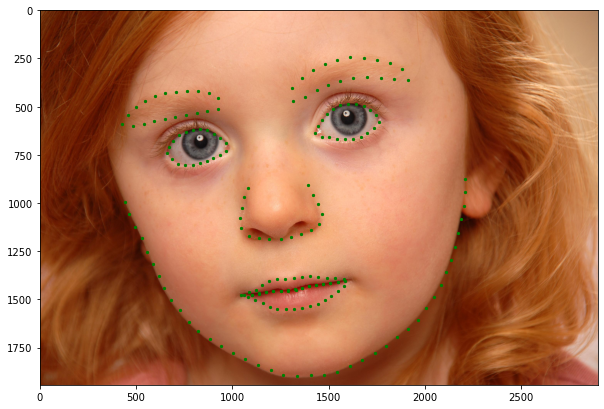

In [2]:
from skimage import io
import matplotlib.pyplot as plt
from math import floor
import numpy as np

landmark_dict = dict() # dictionar {key=nume_fisier, value=lista_puncte_landmark}
for filename in os.listdir('annotation'):
  with open("annotation/"+filename, 'r') as f:
    imagename = f.readline().rstrip('\n')
    content = f.readlines()
    points = []
    for point in content:
      temp = (point[:-1].split(" , "))
      points.append([floor(float(temp[0])), floor(float(temp[1]))])
    landmark_dict[imagename] = points
    

#images_dict = dict() # dictionar {key=nume_fisier, value=imaginea}
#for filename in os.listdir('all_helen'):
#  images_dict[filename[:-4]] = io.imread("all_helen/"+filename)# nume fara extensia .jpg

point = landmark_dict['3247810519_1']
point = np.array(point)

img = io.imread("all_helen/3247810519_1.jpg")
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.scatter(point[:,0], point[:,1], s = 5, c = 'g')
plt.show()





In [3]:
!pip install mtcnn

# sursa: https://github.com/ipazc/mtcnn

     |████████████████████████████████| 2.3MB 13.3MB/s 


Celula de test:
setare variabila **filename** 

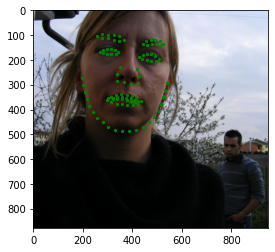

No face detected, sorry!


In [4]:
from mtcnn import MTCNN
import cv2
import random
import imutils
from PIL import Image
from math import cos, sin, radians
from torchvision import transforms
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

cropped_image_size = 224
filename = '2393479404_1'
angle_range = 10

# x, y coordonate box fata stanga sus
# w, h dimensiune box fata
# central coordonatele punctului central din landmark
def face_detected(x, y, w, h, central):
  if (x<0) or (y<0) or (w<0) or (h<0):
    return False
  # verificam daca un punct central (landmark la nas) se afla in box  
  x_central, y_central = central 
  if not ((x_central>x) and (x_central<x+w) and (y_central>y) and (y_central<y+h)):
    return False
  return True

# printare imagine si landmark suprapus
def print_face_and_landmark(img, landmark):
  plt.imshow(img)
  plt.scatter(landmark[:,0], landmark[:,1], s = 5, c = 'g')
  plt.show()

# detectare fata prin MTCNN (Multi-task Cascaded Convolutional Networks)
def detect_face(img):
  detector = MTCNN()
  return detector.detect_faces(img)[0]['box']

# crop imagine si actualizare landmark
def crop_face(img, landmarks, x, y, w, h):
  cropped = img[y:y+h, x:x+w]
  # landmark-ul doar se translateaza cu x,y stabilite
  landmarks_cropped = landmarks - [x,y]
  return cropped, landmarks_cropped

# modificarea dimensiune imagine si actualizare landmark
def resize_image(img, landmarks, w, h):
  cropped_resized = cv2.resize(img,(cropped_image_size, cropped_image_size))
  landmarks_cropped_resized = landmarks*[cropped_image_size/w,cropped_image_size/h]
  return cropped_resized, landmarks_cropped_resized

# rotire imagine (cu un numar aleatoriu de grade) si actualizare landmark
def rotate_image(img, landmarks):
  angle = random.uniform(-angle_range, +angle_range)
  np_image = imutils.rotate(np.array(img), angle)

  # https://www.sciencedirect.com/topics/computer-science/image-rotation
  rotational_center = np.array([cropped_image_size/2, cropped_image_size/2])
  # matrice de rotatie (https://en.wikipedia.org/wiki/Rotation_matrix)
  transformation_matrix = np.array([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
            ])
  landmarks = landmarks-rotational_center
  landmarks_rotated = np.matmul(landmarks, transformation_matrix)
  landmarks_rotated = landmarks_rotated+rotational_center

  return Image.fromarray(np_image), landmarks_rotated

# schimbare random de stralucire si saturatie
def add_color_jitter(img):
  color_jitter = transforms.ColorJitter(brightness=0.3, 
                                        contrast=0.3,
                                        saturation=0.3, 
                                        hue=0.1)
  img = color_jitter(img)
  return img


##### PART I - START
# Code de test: pentru a vizualiza operatiile de transformarea pentru o imagine
img = cv2.cvtColor(cv2.imread("all_helen/"+filename+".jpg"), cv2.COLOR_BGR2RGB)
landmarks = np.array(landmark_dict[filename])
landmarks = landmarks[::2, :] # pentru ca sunt prea multe se elimina jumatate din punctele de landmark  
print_face_and_landmark(img, landmarks)

detector = MTCNN()
[x, y, w, h] = detect_face(img)
# !!! problema: poate sa nu detecteze nicio fata (e.g. 2393479404_1) sau poate detecta o alta fata
# decat cea pentru care e disponibil landmark-ul (in cazul imaginilor cu mai multe fete e.g. 2125467698_1)
fd = face_detected(x, y, w, h, landmarks[int(landmarks.shape[0]/2), :])

if fd:
  cropped_img, landmarks_after_crop = crop_face(img, landmarks, x, y, w, h)
  print_face_and_landmark(cropped_img, landmarks_after_crop)

  cropped_img_resized, landmarks_after_resize = resize_image(cropped_img, landmarks_after_crop, w, h)
  print_face_and_landmark(cropped_img_resized, landmarks_after_resize)

  rotated_img, landmarks_after_rotate = rotate_image(cropped_img_resized, landmarks_after_resize)
  print_face_and_landmark(rotated_img, landmarks_after_rotate)

  color_jitter_img = add_color_jitter(rotated_img)
  print_face_and_landmark(color_jitter_img, landmarks_after_rotate)

  color_jitter_img = np.array(color_jitter_img)
  final_img = rgb2gray(color_jitter_img)
  final_landmarks = landmarks_after_rotate
  plt.imshow(final_img, cmap=plt.cm.gray)
  plt.scatter(final_landmarks[:,0], final_landmarks[:,1], s = 5, c = 'g')
  plt.show()
else:
  print("No face detected, sorry!")


##### PART I - STOP

In [68]:
# Preprocesare: prelucrare baza de date

# img, landmark - imaginea si landmarkul initial
# functia aplica urmatoarele operatii asupra imaginii
# si a landmark-ului acolo unde e cazul:
#
#

def transformations(img, landmark, crop_box):
  x, y, w, h = crop_box
  img, landmark = crop_face(img, landmark, x, y, w, h)
  img, landmark = resize_image(img, landmark, w, h)
  img, landmark = rotate_image(img, landmark)
  img = add_color_jitter(img)
  img = np.array(img)
  img = rgb2gray(img)
  return img, landmark

class Transforms():
  def __init__(self):
    pass
    
  def __call__(self, image, landmarks, crop_box):
    image, landmarks = transformations(image, landmarks, crop_box)
        
    #image = TF.normalize(image, [0.5], [0.5])
    return image, landmarks

#for fn in landmark_dict[:5]:
#  path_to_file = "all_helen/"+fn+".jpg"
#  print("File: {}".format(path_to_file))
#  img = cv2.cvtColor(cv2.imread(path_to_file), cv2.COLOR_BGR2RGB)
#  landmarks = np.array(landmark_dict[fn])
#  landmarks = landmarks[::2, :]
#  detector = MTCNN()
#  [x, y, w, h] = detect_face(img)
#  fd = face_detected(x, y, w, h, landmarks[int(landmarks.shape[0]/2), :])
#  if fd:
#    img, landmarks = transformations(img, landmarks, [x, y, w, h])
#    plt.imshow(img, cmap=plt.cm.gray)
#    plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
#    plt.show()
#  else:
#    print("No correct face detected, sorry!")


  


all_helen/106348540_1.jpg
247 61 416 539


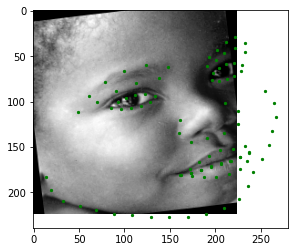

In [80]:
from torch.utils.data import Dataset
from random import shuffle

class FaceLandmarksDataset(Dataset):

  def __init__(self):

    self.image_filenames = []
    self.landmarks = []

    for filename in os.listdir('annotation'):
      with open("annotation/"+filename, 'r') as f:
        imagename = f.readline().rstrip('\n')
        self.image_filenames.append(imagename)
        content = f.readlines()
        points = []
        for point in content:
          temp = (point[:-1].split(" , "))
          points.append([floor(float(temp[0])), floor(float(temp[1]))])
        landmark = np.array(points)
        landmark = landmark[::2, :]
        self.landmarks.append(landmark)
    # shuffle pe ambele liste in mod similar
    image_filenames_shuf = []
    landmarks_shuf = []
    index_shuf = list(range(len(self.image_filenames)))
    shuffle(index_shuf)
    for i in index_shuf:
      image_filenames_shuf.append(self.image_filenames[i])
      landmarks_shuf.append(self.landmarks[i])
    self.image_filenames = image_filenames_shuf
    self.landmarks = landmarks_shuf

  def __len__(self):
    return len(self.image_filenames)

  def __getitem__(self, index):
    path_to_file = "all_helen/"+self.image_filenames[index]+".jpg"
    print(path_to_file)
    image = cv2.cvtColor(cv2.imread(path_to_file), cv2.COLOR_BGR2RGB)

    #print(self.landmarks)
    landmark = self.landmarks[index]

    crop_box = detect_face(image)
    x, y, w, h = crop_box
    print(x, y, w, h)
    fd = face_detected(x, y, w, h, landmark[int(landmark.shape[0]/2), :])
    if (fd):
      image, landmarks = transformations(image, landmark, crop_box)
      return True, image, landmarks
    else:
      return False, None, None

dataset = FaceLandmarksDataset()

result, image, landmark = dataset[0]
if result:
  plt.imshow(image, cmap=plt.cm.gray)
  plt.scatter(landmark[:,0], landmark[:,1], s = 5, c = 'g')
  plt.show()
else:
  print("nope!")